In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groupNum = input("Enter number of groups: ")

Enter number of centroids: 7
Enter number of groups: 5


In [3]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 

In [4]:
#calculuates loss by putting euclidean distance of point->centroid into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*(distance))) #converts distances to probability distribution
    #return loss
    return loss

In [5]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids, subgroup_loss):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  max_val = df['min_loss'].max()
  min_val = df['min_loss'].min()
  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  #weighting scheme for 2-part cost function (sum of individual losses and subgroup loss)
  tot_loss = .8*(loss_sum/tot_len)
  tot_loss += ((1-.8)*subgroup_loss)
  print(subgroup_loss)
  return tot_loss


In [6]:
def assign_cluster(df, centroids):
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]
  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)
  for i in range(len(centroids)):
    del df['loss_from_{}'.format(i)]
    lst = df['min_centr'].unique()
    if i not in lst:
      del df['dist_from_{}'.format(i)]
  return df

In [7]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [8]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):
  #total number of points in cluster 0 (points nearest to centroid 0)
  new_centr_x, new_centr_y = centr[0], centr[1]
  #calculate partial derivatives of euclidean distance functions
  x = clust['x_coord']
  y = clust['y_coord']
  center = clust['min_centr']
  distance = clust['dist_from_{}'.format(int(center))]
  grad_x = (np.exp(-1*distance) * (x - centr[0])) / (1 + np.exp(-1*distance)*distance)
  grad_y = (np.exp(-1*distance) * (y - centr[1])) / (1 + np.exp(-1*distance)*distance)

  return (grad_x, grad_y)

In [9]:
def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=0)

In [10]:
import random
def mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1,cdf2):
  #weighted mini-batch sampling
  samples = []
  group_loss = []
  for group in groups:
    group_loss.append(group['min_loss'].sum()/len(group))
  weights = softmax(group_loss)
  print('weights: ', weights)
  for i, group in enumerate(groups):
    samples.append(group.sample(n=int(b*weights[i]), random_state=1))
  samp = pd.concat([samp for samp in samples], ignore_index=True, sort=False)
  samp = samp.reset_index()
  #initializations
  sum_x = {}
  for i in centroids.keys():
    sum_x[i] = 0
  sum_y = {}
  for i in centroids.keys():
    sum_y[i] = 0
  for i in centroids.keys():
    count[i] = 0
  start = time.time()
  #update centroid locations using gradient descent
  for s in range(len(samp)):
    clust = samp.iloc[s]['min_centr']
    clust = int(clust)
    count[clust]+=1
    lr = 1/count[clust]
    temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
    sum_x[clust] += temp[0]
    sum_y[clust] += temp[1]
  for i in range(len(temp_centroids)):
    if count[i]!= 0:
      temp_centroids[i] = (temp_centroids[i][0]-lr*(sum_x[i]/count[i]), temp_centroids[i][1]-lr*(sum_y[i]/count[i]))
  end = time.time()
  print('Time elapsed Batch Step: ', end - start)
  return temp_centroids

In [11]:
#updates centroid locations based on gradient descent and loss constraint
def update(centroids, df, subgroup_loss, loss, groups, cdf1, cdf2):
  #initializations
  tot_loss_lst = []
  prev_centr = {}
  for i in centroids.keys():
    prev_centr[i] = 0
  b = 1000
  max_iter = 150
  iter_num = 0
  conv = 10
  j = 0
  tot_loss_lst.append(loss)
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  count = {}
  #beginning of updating 
  while iter_num < max_iter:
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    temp_centroids = mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1, cdf2)
    #testing to see if new centroid locations improve summation of individual loss
    temp_df = assign_cluster(df, temp_centroids)
    groups = compute_groups(temp_df)
    cdf1, cdf2 = compute_cdf(groups)
    temp_subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    temp_loss = sum_loss(temp_df, temp_centroids, temp_subgroup_loss)
    iter_num += 1
    if old_loss != temp_loss and j < conv:
      #only change centroid locations if it improves subgroup loss
      if old_loss > temp_loss:
        subgroup_loss = temp_subgroup_loss
        loss = temp_loss
        df = temp_df
        groups = compute_groups(df)
        compute_cdf_graph(groups)
        for i in prev_centr.keys():
          prev_centr[i] = centroids[i]
        for i in centroids.keys():
          centroids[i] = temp_centroids[i]
        print('c ', centroids)
        j = 0
      else:
        j += 1
      # loss = sum_loss(temp_df, centroids, subgroup_loss)
      tot_loss_lst.append(loss)
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      #plot overall cost 
      plt.title('Cost per iteration')
      plt.plot(tot_loss_lst)
      plt.show()
      return centroids
  #plot overall cost
  plt.title('Cost per iteration')
  plt.plot(tot_loss_lst)
  plt.show()
  print('Reached max iterations')
  print('prev centroids: ', prev_centr)
  return centroids    

In [12]:
def compute_cdf(groups):
  lst = []
  perc = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    perc.append(stats.scoreatpercentile(subgroup, 50))
  min_ind = perc.index(min(perc))
  max_ind = perc.index(max(perc))
  return (max_ind, min_ind)

In [13]:
def compute_cdf_graph(groups):
  #this function creates the cdf graph of all subgroups
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()

In [14]:
def compute_groups(df):
  #divides the dataframe by subgroup membership
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups

In [15]:
def compute_clusters(df):
  #divides dataframe by centroid membership
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters

Time elapsed Assignment Step:  2.22133207321167


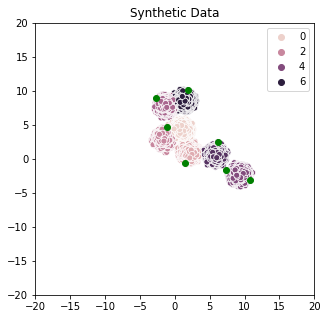

{0: (-1.0663934097032313, 4.624169911927073),
 1: (10.836064212369346, -3.0623102789556764),
 2: (6.166903940066983, 2.496484593220087),
 3: (1.8585901993874387, 10.148803538887215),
 4: (1.389696917541647, -0.5689010826849061),
 5: (-2.632564014227559, 8.895627374980425),
 6: (7.344879251146389, -1.5996807567112303)}

In [16]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
import random
import sys
from operator import itemgetter

# Generate Imbalanced Synthetic Data
center_box = (0,20)
# X,y = make_classification(n_samples=800000, n_classes=int(groupNum),shift=15 ,n_informative=4, n_redundant=0,n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.65,.15, .12, .08], random_state=55)
X, y = make_blobs(n_samples=800000, centers=int(centroids), n_features=2, cluster_std=.4,random_state=0)
# X, y = make_blobs(n_samples=1000000, centers=int(groups), n_features=2,center_box=center_box,random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]})

numList = [i for i in range(int(groupNum))]
df['group'] = y

 
#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
centroids[0] = ((random.choice(X[:,0])), (random.choice(X[:,1])))
       
#K-Means++ 
for c in range(k - 1): 
  ## initialize a list to store distances of data 
  ## points from nearest centroid 
  dist = [] 
  for i in range(df.shape[0]): 
    point = (df['x_coord'][i],df['y_coord'][i])  
    d = sys.maxsize 
                                                                      
    ## compute distance of 'point' from each of the previously 
    ## selected centroid and store the minimum distance 
    for j in range(len(centroids)): 
      temp_dist = calc_dist(point[0], point[1], centroids[j][0], centroids[j][1]) 
      d = min(d, temp_dist) 
    dist.append(d) 
              
  ## select data point with maximum distance as our next centroid 
  dist = np.array(dist) 
  next_centroid = (df['x_coord'][np.argmax(dist)], df['y_coord'][np.argmax(dist)]) 
  centroids[c+1] = (next_centroid) 
  dist = [] 

#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)
for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
ax.set_title("Synthetic Data")
plt.show()

centroids

Time elapsed Assignment Step:  2.043123245239258


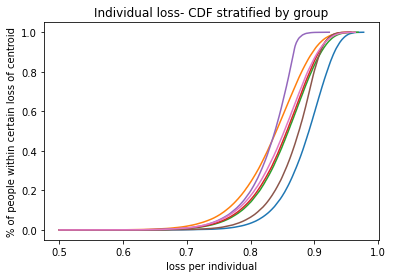

0.05323106909931341
weights:  [0.14770429 0.14023449 0.142951   0.14252363 0.13951559 0.14508495
 0.14198606]
Time elapsed Batch Step:  0.4118466377258301
Time elapsed Assignment Step:  2.0691235065460205
0.05312345323960144
weights:  [0.14769129 0.14024266 0.14294113 0.14252909 0.13951876 0.14508442
 0.14199265]
Time elapsed Batch Step:  0.4355337619781494
Time elapsed Assignment Step:  2.081970691680908
0.053015113727292396
weights:  [0.14767833 0.14025082 0.1429313  0.14253453 0.13952192 0.14508386
 0.14199923]
Time elapsed Batch Step:  0.4132578372955322
Time elapsed Assignment Step:  2.0687971115112305
0.05291995976491537
weights:  [0.14766539 0.14025898 0.1429215  0.14253997 0.13952507 0.1450833
 0.1420058 ]
Time elapsed Batch Step:  0.4042544364929199
Time elapsed Assignment Step:  2.0834288597106934
0.05280904880721449
weights:  [0.14765257 0.14026706 0.14291179 0.14254534 0.13952817 0.14508278
 0.14201229]
Time elapsed Batch Step:  0.42577552795410156
Time elapsed Assignment S

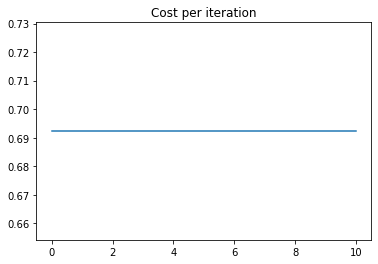

{0: (-1.0663934097032313, 4.624169911927073),
 1: (10.836064212369346, -3.0623102789556764),
 2: (6.166903940066983, 2.496484593220087),
 3: (1.8585901993874387, 10.148803538887215),
 4: (1.389696917541647, -0.5689010826849061),
 5: (-2.632564014227559, 8.895627374980425),
 6: (7.344879251146389, -1.5996807567112303)}

In [18]:
df = assign_cluster(df, centroids)
groups = compute_groups(df)
compute_cdf_graph(groups)
clusters = compute_clusters(df)
cdf1, cdf2 = compute_cdf(groups)
#subgroup loss between max and min loss
subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
loss = sum_loss(df, centroids, subgroup_loss)
update(centroids,df, subgroup_loss, loss, groups, cdf1, cdf2)

In [ ]:
df.head(30)

In [ ]:
df = assign_cluster(df, centroids)
df